In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


c:\Users\PC\Data\ads_fraud_detection


In [2]:
from config.config import *
from libs.common import *

c:/Users/PC/Data/ads_fraud_detection


In [3]:
save_dir=f"{exps_dir}/exp2"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



In [4]:
file = f'{data_dir}/fraud_oracle.csv'
data = pd.read_csv(file,index_col=False)
data

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,35,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,15416,5,400,4,more than 30,more than 30,2 to 4,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,30,Policy Holder,Sedan - Liability,Sport,30000 to 39000,0,15417,11,400,3,more than 30,more than 30,more than 4,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,24,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,15418,4,400,4,more than 30,more than 30,more than 4,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,34,Third Party,Sedan - All Perils,Sedan,20000 to 29000,0,15419,6,400,4,more than 30,more than 30,none,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


In [5]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy'], dtype='object')

In [6]:
data.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [8]:
import pandas as pd

data['week_claimed'] = data['Year'].astype(str) + '-' + data['MonthClaimed'].astype(str) + '-' + data['WeekOfMonthClaimed'].astype(str)+ '-' + data['DayOfWeekClaimed'].astype(str)
data['week_incident'] = data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['WeekOfMonth'].astype(str) + '-' + data['DayOfWeek'].astype(str)



In [9]:
category_cols=list(data.select_dtypes('object').columns)

In [10]:
numeric_cols=list(data.select_dtypes('number').columns)

In [11]:
data[category_cols]=data[category_cols].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Month                 15420 non-null  category
 1   WeekOfMonth           15420 non-null  int64   
 2   DayOfWeek             15420 non-null  category
 3   Make                  15420 non-null  category
 4   AccidentArea          15420 non-null  category
 5   DayOfWeekClaimed      15420 non-null  category
 6   MonthClaimed          15420 non-null  category
 7   WeekOfMonthClaimed    15420 non-null  int64   
 8   Sex                   15420 non-null  category
 9   MaritalStatus         15420 non-null  category
 10  Age                   15420 non-null  int64   
 11  Fault                 15420 non-null  category
 12  PolicyType            15420 non-null  category
 13  VehicleCategory       15420 non-null  category
 14  VehiclePrice          15420 non-null  category
 15  Fr

In [12]:
data.duplicated().sum()

0

In [13]:
data.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
week_claimed            0
week_incident           0
dtype: int64

In [14]:
print(f"Bien phan loai: {len(category_cols)}, Bien lien tuc: {len(numeric_cols)}")

Bien phan loai: 26, Bien lien tuc: 9


In [15]:
data[category_cols].describe()

,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Sex,MaritalStatus,Fault,PolicyType,VehicleCategory,VehiclePrice,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy,week_claimed,week_incident
count,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420
unique,12,7,19,2,8,13,2,4,2,9,3,6,5,4,4,8,9,2,2,2,4,5,5,3,943,1175
top,Jan,Monday,Pontiac,Urban,Monday,Jan,Male,Married,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,more than 30,more than 30,2 to 4,7 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision,1994-Jan-2-Monday,1994-May-4-Monday
freq,1411,2616,3837,13822,3757,1446,13000,10625,11230,5584,9671,8079,15247,15342,5485,5807,5593,14992,15333,15179,7047,14324,14316,5962,51,35


In [16]:
for column in category_cols: 
    print("\033[1m","*, Column: ", column,"\033[0m")   
    print('\t',len(data[column].unique()), "unique values", "\t & \t", 
          data[column].notnull().sum(), "non-null values\t", 
          round(100* data[column].notnull().sum()/len(data[column]),2), 
          "% non-null") 
    if len(data[column].unique())<=10:
            print('\t',data[column].unique())


 *, Column:  Month 
	 12 unique values 	 & 	 15420 non-null values	 100.0 % non-null
 *, Column:  DayOfWeek 
	 7 unique values 	 & 	 15420 non-null values	 100.0 % non-null
	 ['Wednesday', 'Friday', 'Saturday', 'Monday', 'Tuesday', 'Sunday', 'Thursday']
Categories (7, object): ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
 *, Column:  Make 
	 19 unique values 	 & 	 15420 non-null values	 100.0 % non-null
 *, Column:  AccidentArea 
	 2 unique values 	 & 	 15420 non-null values	 100.0 % non-null
	 ['Urban', 'Rural']
Categories (2, object): ['Rural', 'Urban']
 *, Column:  DayOfWeekClaimed 
	 8 unique values 	 & 	 15420 non-null values	 100.0 % non-null
	 ['Tuesday', 'Monday', 'Thursday', 'Friday', 'Wednesday', 'Saturday', 'Sunday', '0']
Categories (8, object): ['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
 *, Column:  MonthClaimed 
	 13 unique values 	 & 	 15420 non-null values	 100.0 % non-null
 *, Column:  Sex 
	 2 u

### Nhận xét: 
Một số cột phân loại xuất hiện giá trị none, khi xử lý dữ liệu cần lưu ý điểm này để tránh bỏ qua sai sót, chúng ta nhận xét thấy một vài cột, chẳng hạn có giá trị none như Days_Policy_Claim, PastNumberOfClaims, NumberOfSuppliments có thể ảnh hưởng đến bộ dữ liệu. Khi chúng ta tiến hành phân tích sâu hơn, chúng ta nhận định thấy rằng những giá trị none này hoàn toàn không ảnh hưởng đến hiệu suất học máy. Nên chúng ta cân nhắc về sau

In [17]:
nulldata_categorical=(data[category_cols]=='none').sum()
nulldata_categorical

Month                      0
DayOfWeek                  0
Make                       0
AccidentArea               0
DayOfWeekClaimed           0
MonthClaimed               0
Sex                        0
MaritalStatus              0
Fault                      0
PolicyType                 0
VehicleCategory            0
VehiclePrice               0
Days_Policy_Accident      55
Days_Policy_Claim          1
PastNumberOfClaims      4352
AgeOfVehicle               0
AgeOfPolicyHolder          0
PoliceReportFiled          0
WitnessPresent             0
AgentType                  0
NumberOfSuppliments     7047
AddressChange_Claim        0
NumberOfCars               0
BasePolicy                 0
week_claimed               0
week_incident              0
dtype: int64

In [18]:
for column in category_cols:
    if len(data[column].unique())<=10:
        print('-'*100)
        print("*, Column: ", column)
        print(data[column].value_counts())
        print('-'*100)
    

----------------------------------------------------------------------------------------------------
*, Column:  DayOfWeek
DayOfWeek
Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
*, Column:  AccidentArea
AccidentArea
Urban    13822
Rural     1598
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
*, Column:  DayOfWeekClaimed
DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
0               1
Name: count, dtype: int64
-

In [19]:
for column in category_cols:
    if len(data[column].unique())<=40:
        data[column].value_counts().iplot(kind='bar',title=column, 
                                        xTitle=column, 
                                        yTitle='Values')


In [20]:
data[numeric_cols].describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [21]:
for column in numeric_cols: 
    print("*, Column: ", column)   
    print(len(data[column].unique()), "unique values", "\t & \t", 
          data[column].notnull().sum(), "non-null values\t", 
          round(100* data[column].notnull().sum()/len(data[column]),2), 
          "% non-null")
    if len(data[column].unique())<=10:
        print(data[column].unique())
    

*, Column:  WeekOfMonth
5 unique values 	 & 	 15420 non-null values	 100.0 % non-null
[5 3 2 4 1]
*, Column:  WeekOfMonthClaimed
5 unique values 	 & 	 15420 non-null values	 100.0 % non-null
[1 4 2 3 5]
*, Column:  Age
66 unique values 	 & 	 15420 non-null values	 100.0 % non-null
*, Column:  FraudFound_P
2 unique values 	 & 	 15420 non-null values	 100.0 % non-null
[0 1]
*, Column:  PolicyNumber
15420 unique values 	 & 	 15420 non-null values	 100.0 % non-null
*, Column:  RepNumber
16 unique values 	 & 	 15420 non-null values	 100.0 % non-null
*, Column:  Deductible
4 unique values 	 & 	 15420 non-null values	 100.0 % non-null
[300 400 500 700]
*, Column:  DriverRating
4 unique values 	 & 	 15420 non-null values	 100.0 % non-null
[1 4 3 2]
*, Column:  Year
3 unique values 	 & 	 15420 non-null values	 100.0 % non-null
[1994 1995 1996]


In [22]:
data

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,week_claimed,week_incident
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,1994-Jan-1-Tuesday,1994-Dec-5-Wednesday
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,1994-Jan-4-Monday,1994-Jan-3-Wednesday
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,1994-Nov-2-Thursday,1994-Oct-5-Friday
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,1994-Jul-1-Friday,1994-Jun-2-Saturday
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,1994-Feb-2-Tuesday,1994-Jan-5-Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,35,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,15416,5,400,4,more than 30,more than 30,2 to 4,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision,1996-Nov-5-Tuesday,1996-Nov-4-Friday
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,30,Policy Holder,Sedan - Liability,Sport,30000 to 39000,0,15417,11,400,3,more than 30,more than 30,more than 4,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability,1996-Dec-1-Friday,1996-Nov-5-Thursday
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,24,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,15418,4,400,4,more than 30,more than 30,more than 4,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision,1996-Dec-1-Friday,1996-Nov-5-Thursday
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,34,Third Party,Sedan - All Perils,Sedan,20000 to 29000,0,15419,6,400,4,more than 30,more than 30,none,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils,1996-Dec-2-Thursday,1996-Dec-1-Monday


In [23]:
change_tocategory=[i for i in numeric_cols if len(data[i].unique())<=46]
#change_tocategory.remove('umbrella_limit')
change_tocategory

['WeekOfMonth',
 'WeekOfMonthClaimed',
 'FraudFound_P',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Year']

In [24]:
data[change_tocategory]=data[change_tocategory].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Month                 15420 non-null  category
 1   WeekOfMonth           15420 non-null  category
 2   DayOfWeek             15420 non-null  category
 3   Make                  15420 non-null  category
 4   AccidentArea          15420 non-null  category
 5   DayOfWeekClaimed      15420 non-null  category
 6   MonthClaimed          15420 non-null  category
 7   WeekOfMonthClaimed    15420 non-null  category
 8   Sex                   15420 non-null  category
 9   MaritalStatus         15420 non-null  category
 10  Age                   15420 non-null  int64   
 11  Fault                 15420 non-null  category
 12  PolicyType            15420 non-null  category
 13  VehicleCategory       15420 non-null  category
 14  VehiclePrice          15420 non-null  category
 15  Fr

In [25]:
numeric_cols=list(data.select_dtypes('number').columns)
category_cols=list(data.select_dtypes('category').columns)
print(len(numeric_cols), len(category_cols))


2 33


In [26]:
numeric_cols

['Age', 'PolicyNumber']

In [27]:
for c in numeric_cols:
    data[c].iplot(kind='hist',title=c,xTitle=c)
    plt.show()

### Kết luận:
Ở cột tuổi tác, xuất hiện các giá trijv 0 vốn được xem là các giá trị ngoại lệ cho bộ dữ liệu. Như chúng ta đã biết, trường age, xuất hiện giá trị 0 vốn không phải là một giá trị hợp lệ để chỉ độ tuổi hợp lí của con người

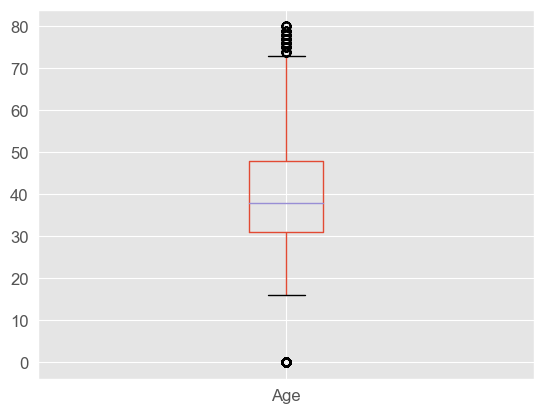

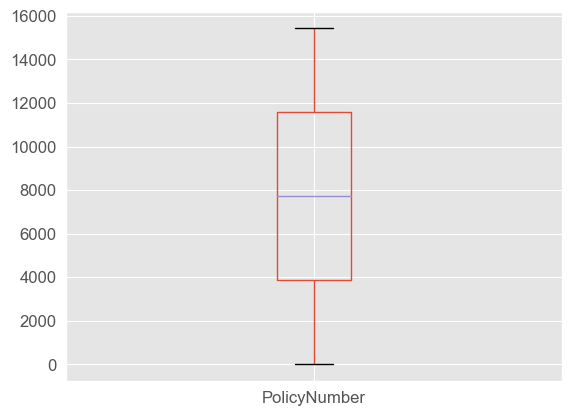

In [28]:
numeric_columns=data.select_dtypes(['number']).columns
for c in numeric_columns:
    plt.figure()
    data.boxplot(c, rot=0, grid=True, fontsize=12);
    plt.show()

In [29]:
def check_outliers(name,outliers_list):
    we=data[name].values
    Q1=np.quantile(we,0.25)
    Q3=np.quantile(we,0.75)
    IQR=Q3-Q1
    print("Q1: ",Q1,"Q3: ",Q3,"IQR:",IQR)
    outliers=np.unique(we[[(n<Q1-1.5*IQR)|(n>Q3+1.5*IQR) for n in we]])
    indexes=[we.tolist().index(i) for i in outliers]
    if len(indexes)>0:
        outliers_list.append(name)
    print("Indexes of outliers: ", indexes)
    print("Number of outliers: ", len(indexes))
    print("Outlier values", we[indexes])
    print("-----")

In [30]:
outliers_list=[]
for col in numeric_columns:
    check_outliers(col,outliers_list)
np.savez(f'{save_dir}/outliers.npz', outliers = outliers_list)

print(outliers_list)

Q1:  31.0 Q3:  48.0 IQR: 17.0
Indexes of outliers:  [7, 88, 303, 640, 295, 273, 1002, 347]
Number of outliers:  8
Outlier values [ 0 74 75 76 77 78 79 80]
-----
Q1:  3855.75 Q3:  11565.25 IQR: 7709.5
Indexes of outliers:  []
Number of outliers:  0
Outlier values []
-----
['Age']


In [31]:
corrle=data[numeric_columns].corr()
corrle

,Age,PolicyNumber
Age,1.000000,0.025944
PolicyNumber,0.025944,1.000000


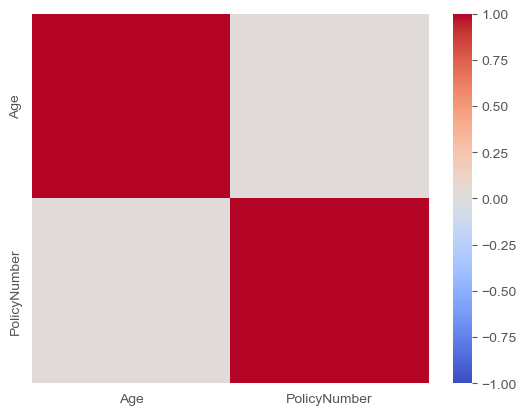

In [32]:
sns.heatmap(corrle,vmin=-1,vmax=1, annot=False, fmt=".2f",cmap='coolwarm')
plt.show()

In [33]:
fraud_counts = data['FraudFound_P'].value_counts().reset_index()
fraud_counts.columns = ['FraudFound_P', 'Count']
fraud_counts

,FraudFound_P,Count
0,0,14497
1,1,923


In [34]:
# Pie Chart
fig = px.pie(fraud_counts, names='FraudFound_P', values='Count', color='FraudFound_P',
            color_discrete_map={0: '#87CEFA', 1:'FF6F61'})

fig.update_traces(
    textinfo='percent',
    textfont={'size': 16, 'color': 'Black'},
    marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title={
        'text': 'Target Balance',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.show()

In [35]:
df_fraud = data[data['FraudFound_P'] == 1]

fraud_counts_sex = df_fraud['Sex'].value_counts()
fraud_percentages_sex = (fraud_counts_sex / fraud_counts_sex.sum()) * 100
fraud_percentages_sex

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=fraud_counts_sex.index, y=fraud_counts_sex.values,
                    text=[f'{count} ({percentage:.2f}%)' for count, percentage in zip(fraud_counts_sex.values, fraud_percentages_sex)],
                    textposition='auto', marker_color=['rgba(31, 119, 180, 0.6)', 'rgba(255, 127, 14, 0.6)'], width=0.5))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Sex'),
    yaxis=dict(title='Count'),
    showlegend=False)

fig.show()

In [36]:
df_fraud = data[data['FraudFound_P'] == 1]
df_non_fraud = data[data['FraudFound_P'] == 0]

df_counts_age = data['Age'].value_counts().sort_index()
df_counts_fraud = df_fraud['Age'].value_counts().sort_index()

df_percentages_fraud = round((df_counts_fraud / df_counts_age) * 100, 2)

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud.index, y=df_percentages_fraud.values,
    marker_color='rgba(31, 119, 180, 0.7)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Age'), yaxis=dict(title='Percentage', range=[0, 20], dtick=2), legend=dict(title='Outcome'))

fig.add_shape(
    type="line",
    x0=min(df_percentages_fraud.index),
    y0=6,
    x1=max(df_percentages_fraud.index),
    y1=6,
    line=dict(
        color="rgba(255, 0, 0, 0.8)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

In [37]:
df_fraud = data[data['FraudFound_P'] == 1]
df_non_fraud = data[data['FraudFound_P'] == 0]

df_counts_ageofpolicyholder = data['AgeOfPolicyHolder'].value_counts().sort_index()
df_counts_fraud_ = df_fraud['AgeOfPolicyHolder'].value_counts().sort_index()

df_percentages_fraud_ = round((df_counts_fraud_ / df_counts_ageofpolicyholder) * 100, 2)

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud_.index, y=df_percentages_fraud_.values,
    marker_color='rgba(31, 119, 180, 0.7)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age of Policy Holder',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Age of Policy Holder'), yaxis=dict(title='Percentage', range=[0, 20], dtick=2), legend=dict(title='Outcome'))

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=10,
    y1=6,
    line=dict(
        color="rgba(255, 0, 0, 0.8)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

#### Nhận xét:
Chúng ta nhận thấy giá trị ngoại lệ 0 nằm ở khoảng giá trị ngoại lệ và là một giá trị không hợp lí, cần tiến hành cân nhắc loại bỏ để không ảnh hưởng đến mô hình học máy

In [38]:
data.DayOfWeekClaimed.value_counts()

DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
0               1
Name: count, dtype: int64

#### Nhận xét:
Chúng ta nhận xét thấy giá trị 0 có thể là do lỗi đánh máy, nên chúng ta sẽ dùng kĩ thuật ffill để làm mất đi giá trị 0 này

In [39]:
data['DayOfWeekClaimed'].replace('0',np.nan,inplace=True)
data['DayOfWeekClaimed'].fillna(method='ffill')
data.DayOfWeekClaimed.value_counts()

DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
Name: count, dtype: int64

In [40]:
data.Year.value_counts()

Year
1994    6142
1995    5195
1996    4083
Name: count, dtype: int64

<Axes: xlabel='Year'>

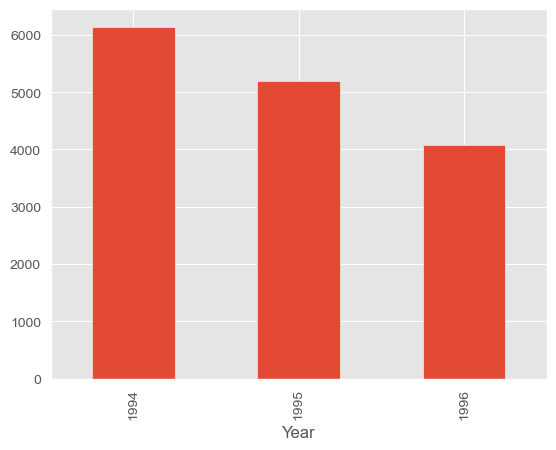

In [41]:
data.Year.value_counts().plot.bar()

In [42]:
BasePolicy=pd.DataFrame(data.BasePolicy.value_counts())
BasePolicy.values.flatten()

array([5962, 5009, 4449], dtype=int64)

In [43]:
def pie_chart(col,data,name,sort=False,top=None):
    if sort:
        field = pd.DataFrame(data[col].value_counts().sort_values(ascending=False).iloc[:top])
    else:
        field = pd.DataFrame(data[col].value_counts())
    labels=list(field.index)
    values=field.values.flatten()
    pie_chart = go.Pie(labels=labels, values=values)

    # Tạo layout (có thể không cần)
    layout = go.Layout(title=name)

    # Tạo figure bằng go.Figure
    fig = go.Figure(data=[pie_chart], layout=layout)
    return fig

    # Vẽ biểu đồ bằng iplot
iplot(pie_chart(col='Make',data=data,name='Percentage of Auto make',sort=True,top=5))


In [44]:
iplot(pie_chart(col='BasePolicy',data=data,name='Percentage of Collision Type'))


In [45]:
df_counts_make = data['Make'].value_counts().sort_index()
df_counts_fraud2 = df_fraud['Make'].value_counts().sort_index()
df_percentages_fraud2 = pd.DataFrame(round((df_counts_fraud2 / df_counts_make) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud2.columns = ['Make', 'Fraud %']
df_percentages_fraud2 = df_percentages_fraud2.sort_values(by=['Fraud %', 'Make'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud2['Fraud %'], y=df_percentages_fraud2['Make'], orientation='h',
    marker_color='lightcoral'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Make',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 30], dtick=2), yaxis=dict(title='Make'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=0,
    x1=6,
    y1=len(df_percentages_fraud2['Make']) - 1,
    line=dict(
        color="rgba(128, 128, 128, 1)",
        width=2,
        dash="dashdot", 
    ),
)

fig.show()

In [46]:
df_counts_vp = data['VehiclePrice'].value_counts().sort_index()
df_counts_fraud3 = df_fraud['VehiclePrice'].value_counts().sort_index()
df_percentages_fraud3 = pd.DataFrame(round((df_counts_fraud3 / df_counts_vp) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud3.columns = ['VehiclePrice', 'Fraud %']
df_percentages_fraud3 = df_percentages_fraud3.sort_values(by=['Fraud %'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud3['Fraud %'], y=df_percentages_fraud3['VehiclePrice'], orientation='h',
    marker_color='#9FF781'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by VehiclePrice',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 16], dtick=2), yaxis=dict(title='VehiclePrice'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=0,
    x1=6,
    y1=5.5,
    line=dict(
        color="rgba(0, 100, 0, 1)",
        width=2,
        dash="dashdot", 
    ),
)

fig.show()

In [47]:
# BasePolicy
df_counts_policy = data['BasePolicy'].value_counts().sort_index()
df_counts_fraud4 = df_fraud['BasePolicy'].value_counts().sort_index()
df_percentages_fraud4 = pd.DataFrame(round((df_counts_fraud4 / df_counts_policy) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud4.columns = ['BasePolicy', 'Fraud %']
df_percentages_fraud4 = df_percentages_fraud4.sort_values(by=['Fraud %'])

# PolicyType
df_counts_policy2 = data['PolicyType'].value_counts().sort_index()
df_counts_fraud5 = df_fraud['PolicyType'].value_counts().sort_index()
df_percentages_fraud5 = pd.DataFrame(round((df_counts_fraud5 / df_counts_policy2) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud5.columns = ['PolicyType', 'Fraud %']
df_percentages_fraud5 = df_percentages_fraud5.sort_values(by=['Fraud %'])

# Bar Chart - Subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('BasePolicy', "PolicyType"))

fig.add_trace(go.Bar(x=df_percentages_fraud4['BasePolicy'], y=df_percentages_fraud4['Fraud %'],
    marker_color='skyblue'), row=1, col=1)

fig.add_trace(go.Bar(x=df_percentages_fraud5['PolicyType'], y=df_percentages_fraud5['Fraud %'],
    marker_color='coral'), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Fraud Detection by BasePolicy & PolicyType',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    }, showlegend=False)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=3,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=9,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x2",
    yref="y2"
)

fig.show()

In [48]:
# Age of Vehicle
df_counts_ageofvehicle = data['AgeOfVehicle'].value_counts().sort_index()
df_counts_fraud6 = df_fraud['AgeOfVehicle'].value_counts().sort_index()
df_percentages_fraud6 = pd.DataFrame(round((df_counts_fraud6 / df_counts_ageofvehicle) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud6.columns = ['AgeOfVehicle', 'Fraud %']
df_percentages_fraud6 = df_percentages_fraud6.sort_values(by=['Fraud %'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud6['Fraud %'], y=df_percentages_fraud6['AgeOfVehicle'], orientation='h',
    marker_color='rgb(255, 165, 0)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age of Vehicle',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 16], dtick=2), yaxis=dict(title='AgeOfVehicle'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=-1,
    x1=6,
    y1=8,
    line=dict(
        color="rgba(0, 100, 0, 1)",
        width=2,
        dash="dashdot", 
    ),
)

fig.show()

In [49]:
# Month
df_counts_month = data['Month'].value_counts().sort_index()
df_counts_fraud7 = df_fraud['Month'].value_counts().sort_index()
df_percentages_fraud7 = pd.DataFrame(round((df_counts_fraud7 / df_counts_month) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud7.columns = ['Month', 'Fraud %']

# MonthClaimed
df_counts_monthclaimed = data['MonthClaimed'].value_counts().sort_index()
df_counts_fraud8 = df_fraud['MonthClaimed'].value_counts().sort_index()
df_percentages_fraud8 = pd.DataFrame(round((df_counts_fraud8 / df_counts_monthclaimed) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud8.columns = ['MonthClaimed', 'Fraud %']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Bar Chart - Subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Month', "MonthClaimed"))

fig.add_trace(go.Bar(x=df_percentages_fraud7['Month'], y=df_percentages_fraud7['Fraud %'],
    marker_color='#8A2BE2'), row=1, col=1)

fig.add_trace(go.Bar(x=df_percentages_fraud8['MonthClaimed'], y=df_percentages_fraud8['Fraud %'],
    marker_color='#FF4500'), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Fraud Detection by Month & MonthClaimed',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    }, showlegend=False,
    xaxis=dict(categoryorder='array', categoryarray=month_order),
    xaxis2=dict(categoryorder='array', categoryarray=month_order))

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=12,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=12.5,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)", 
        width=2,
        dash="dashdot",
    ),
    xref="x2",
    yref="y2"
)

fig.show()

In [50]:
data.to_excel(f'{save_dir}/data_EDA.xlsx', index=None)
object_columns = list(data.select_dtypes(['object']).columns)
data[object_columns]=data[object_columns].astype('category')
category_columns = list(data.select_dtypes(['category']).columns)
numeric_columns = list(data.select_dtypes(['number']).columns)

np.savez(f'{save_dir}/columns_dtype.npz', category_columns = category_columns, numeric_columns = numeric_columns)
data.to_csv(f'{save_dir}/data_EDA.csv',index=None)
